In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns

In [2]:
# software = pl.DataFrame()
# for i in range(400):
#     software = pl.concat([
#         software,
#         pl.read_parquet(f"datasets/patents/software-000000000{i:03d}.parquet")
#     ])

In [3]:
# robots = pl.read_parquet('datasets/patents/robots.parquet')

In [4]:
work_context = pd.read_csv('datasets/db_24_3_text/Work Context.txt', sep='\t')

In [5]:
offshorability = work_context[
    work_context['Element Name'].eq('Face-to-Face Discussions')
    | work_context['Element Name'].eq('Outdoors, Exposed to Weather')
]
offshorability = (
    pl.from_dataframe(offshorability)
    .with_columns(
        pl.col('Data Value').truediv(100).mul(pl.col('Category'))
    )
    .group_by('O*NET-SOC Code', 'Element ID')
    .agg(pl.col('Data Value').sum())
    .group_by('O*NET-SOC Code')
    .agg(pl.col('Data Value').mean())
    .with_columns(
        pl.col('O*NET-SOC Code').str.slice(0, 7).alias('SOC Code')
    )
    .group_by('SOC Code')
    .agg(pl.col('Data Value').mean().alias('offshorability'))
)

In [53]:
# aii = pl.read_csv('datasets/aii-robot-exposure.csv')
# aii = pl.read_csv('datasets/aii-software-exposure.csv')
aii = pl.read_parquet('datasets/aii.parquet') # as-is
# aii = pl.read_csv('datasets/robots-exposure.csv').with_columns(
# aii = pl.read_csv('datasets/software-exposure.csv').with_columns(
#     pl.col('exposure').mul(100).map_elements(np.log10).alias('aii')
# )

In [27]:
ipums = pl.read_parquet('datasets/ipums4.parquet', use_pyarrow=True)

In [28]:
def map_edu(val):
    if val < 3:
        return 'edu_0' # low
    elif 3 <= val < 7:
        return 'edu_1' # mid
    else:
        return 'edu_2' # high

def map_edu_demographic(val):
    if val < 6:
        return 'edu_0_low'
    elif val == 6:
        return 'edu_1_high_school'
    elif 6 < val <= 10:
        return 'edu_2_some_college'
    else:
        return 'edu_3_college'

def map_race(val):
    if val == 1:
        return 'white'
    elif val == 2:
        return 'black'
    else:
        return 'other'

In [29]:
ipums = (
    ipums
    .filter(pl.col('AGE').ge(18) & pl.col('AGE').le(65))
    .filter(pl.col('WORKEDYR').eq(3))
    .filter(pl.col('SEX').ne(9))
    .filter(pl.col('EDUC').ne(99))
    .filter(pl.col('AGE').ne(999))
    .filter(~pl.col('INCWAGE').is_in([999998, 999999]))
    .with_columns(
        pl.col('PERWT').truediv(100).mul(pl.col('UHRSWORK').truediv(35)).alias('FTE'),
        pl.col('EDUC').map_elements(map_edu_demographic).alias('EDUC_CAT'),
        pl.col('RACE').map_elements(map_race).alias('RACE_CAT'),
        pl.col('AGE').cut(np.arange(23, 65, 5)).alias('AGE_CAT'),
    )
)

In [30]:
ipums80 = (
    ipums
    .filter(pl.col('YEAR').eq(1980))
    .group_by('SEX', 'RACE_CAT', 'EDUC_CAT', 'AGE_CAT')
    .agg(
        pl.col('FTE').sum()
    )
)

ipums10 = (
    ipums
    .filter(pl.col('YEAR').eq(2010))
    .group_by('SEX', 'RACE_CAT', 'EDUC_CAT', 'AGE_CAT')
    .agg(
        pl.col('FTE').sum()
    )
)

In [31]:
demo_controlled = (
    ipums80
    .join(
        ipums10,
        how='left',
        on=['SEX', 'RACE_CAT', 'EDUC_CAT', 'AGE_CAT'],
        suffix='_2010'
    )
    .with_columns(
        pl.col('FTE').truediv(pl.col('FTE').sum()).alias('w80'),
        pl.col('FTE_2010').truediv(pl.col('FTE_2010').sum()).alias('w10'),
    )
    .with_columns(
        pl.col('w80').truediv(pl.col('w10')).alias('W_ADJ'),
    )
)

In [32]:
edu = (
    ipums
    .filter(pl.col('YEAR').eq(1980))
    .group_by('OCC1990')
    .agg(
        pl.col('FTE').sum(),
        pl.col('EDUC').mul(pl.col('FTE')).sum(),
    )
    .with_columns(
        pl.col('EDUC').truediv(pl.col('FTE')).alias('avg_edu'),
    )
    .with_columns(
        pl.when(pl.col('avg_edu') < pl.col('avg_edu').quantile(1/3)).then('edu_0')
        .when(pl.col('avg_edu') < pl.col('avg_edu').quantile(2/3)).then('edu_1')
        .otherwise('edu_2')
        .alias('edu')
    )
)

/var/folders/0d/380dd3_d27v3p6p6m6nb230h0000gn/T/ipykernel_37167/2359567071.py:13: DeprecationWarning: in a future version, string input will be parsed as a column name rather than a string literal. To silence this warning, pass the input as an expression instead: `pl.lit('edu_0')`
  pl.when(pl.col('avg_edu') < pl.col('avg_edu').quantile(1/3)).then('edu_0')
/var/folders/0d/380dd3_d27v3p6p6m6nb230h0000gn/T/ipykernel_37167/2359567071.py:14: DeprecationWarning: in a future version, string input will be parsed as a column name rather than a string literal. To silence this warning, pass the input as an expression instead: `pl.lit('edu_1')`
  .when(pl.col('avg_edu') < pl.col('avg_edu').quantile(2/3)).then('edu_1')
/var/folders/0d/380dd3_d27v3p6p6m6nb230h0000gn/T/ipykernel_37167/2359567071.py:15: DeprecationWarning: in a future version, string input will be parsed as a column name rather than a string literal. To silence this warning, pass the input as an expression instead: `pl.lit('edu_2')`

In [33]:
# https://www.in2013dollars.com/us/inflation/1980?endYear=2016&amount=1
WAGE_ADJUSTMENT_2016 = 2.91
data80 = (
    ipums
    .filter(pl.col('YEAR').eq(1980))
    .filter(pl.col('IND1990').ge(100) & pl.col('IND1990').lt(400))
    .group_by('OCC1990', 'IND1990')
    .agg(
        pl.col('FTE').sum(),
        pl.col('INCWAGE').mul(pl.col('FTE')).sum(),
    )
    .with_columns(
        pl.col('INCWAGE').mul(WAGE_ADJUSTMENT_2016).truediv(pl.col('FTE')).truediv(40).alias('wage'),
    )
    .with_columns(
        pl.col('wage').clip(pl.col('wage').quantile(.01), pl.col('wage').quantile(.99)) # winsorizing
    )
    .with_columns(
        pl.col('wage').pow(2).alias('wage_sq'),
    )
)

In [34]:
WAGE_ADJUSTMENT_2016 = 1.10
data10 = (
    ipums
    .filter(pl.col('YEAR').eq(2010))
    .filter(pl.col('IND1990').ge(100) & pl.col('IND1990').lt(400))
    .join(
        demo_controlled.select('SEX', 'RACE_CAT', 'EDUC_CAT', 'AGE_CAT', 'W_ADJ'),
        how='left',
        on=['SEX', 'RACE_CAT', 'EDUC_CAT', 'AGE_CAT']
    )
    .with_columns(
        pl.col('FTE').mul(pl.col('W_ADJ'))
    )
    .group_by('OCC1990', 'IND1990', 'OCCSOC')
    .agg(
        pl.col('FTE').sum(),
        pl.col('INCWAGE').mul(pl.col('FTE')).sum(),
    )
    .with_columns(
        pl.col('INCWAGE').mul(WAGE_ADJUSTMENT_2016).truediv(pl.col('FTE')).truediv(40).alias('wage'),
    )
    .with_columns(
        pl.col('wage').clip(pl.col('wage').quantile(.01), pl.col('wage').quantile(.99)) # winsorizing
    )
    .with_columns(
        pl.col('wage').pow(2).alias('wage_sq'),
    )
)

In [54]:
emp_df = (
    data80
    .join(
        data10,
        on=['OCC1990', 'IND1990'],
        how='outer',
        suffix='_10'
    )
    .join(
        (
            aii
            .join(offshorability, how='left', on='SOC Code')
            .with_columns(pl.col('SOC Code').str.replace('-', '').alias('OCCSOC'))
            .select('OCCSOC', 'aii', 'offshorability')
        ),
        how='left',
        on='OCCSOC'
    )
    .join(
        edu.select('OCC1990', 'edu'),
        how='left',
        on='OCC1990'
    )
    .with_columns(
        pl.col('FTE').fill_null(0),
        pl.col('FTE_10').fill_null(0),
    )
    .drop_nulls(subset='aii')
    .with_columns(
        ((pl.col('FTE_10') - pl.col('FTE')) / pl.col('FTE_10').add(pl.col('FTE')).truediv(2)).alias('arc_change'),
        pl.col('wage_10').map_elements(np.log10).sub(pl.col('wage').map_elements(np.log10)).alias('wage_change'),
    )
    .to_pandas()
)

/Users/aliakbars/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/aliakbars/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/aliakbars/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/aliakbars/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

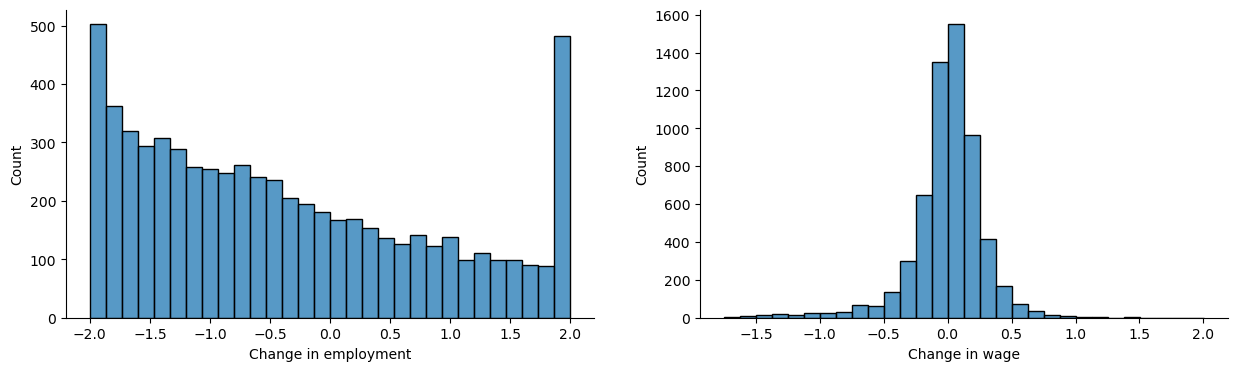

In [55]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 4))
sns.histplot(x=emp_df['arc_change'], bins=30, ax=ax[0])
ax[0].set_xlabel('Change in employment')
sns.histplot(x=emp_df['wage_change'], bins=30, ax=ax[1])
ax[1].set_xlabel('Change in wage')
sns.despine()

/Users/aliakbars/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/aliakbars/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


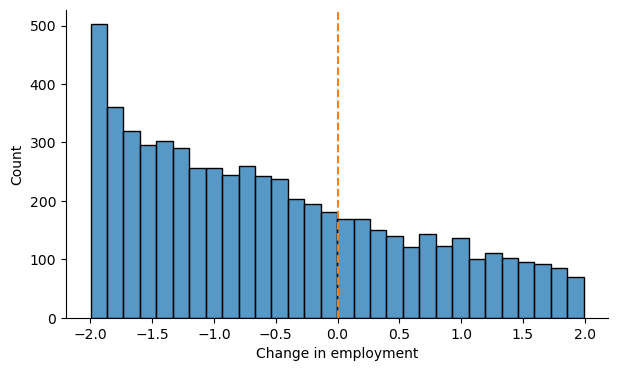

In [37]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.histplot(x=emp_df.dropna()['arc_change'], bins=30, ax=ax)
plt.axvline(0, linestyle='--', color='C1')
plt.xlabel('Change in employment')
sns.despine()

In [61]:
emp_df_filtered = (
    pl.from_dataframe(emp_df)
    .filter(pl.col('arc_change').ne(-2))
    .filter(pl.col('arc_change').ne(2))
    .with_columns(
        pl.col('arc_change').clip(
            pl.col('arc_change').quantile(.01),
            pl.col('arc_change').quantile(.99),
        ).mul(100),
        pl.col('wage_change').mul(100),
        pl.col('IND1990').cast(str).alias('industry'),
    )
    .to_pandas()
)

In [62]:
val, bins = pd.cut(emp_df_filtered.apply(lambda x: [x['aii']] * np.round(x['FTE']).astype(int), axis=1).explode().dropna(), 100, retbins=True)
emp_df_filtered['q_aii'] = pd.cut(emp_df_filtered['aii'], bins).cat.codes

In [96]:
emp_df_filtered

,OCC1990,IND1990,FTE,INCWAGE,wage,wage_sq,OCCSOC,FTE_10,INCWAGE_10,wage_10,wage_sq_10,aii,offshorability,edu,arc_change,wage_change,industry,q_aii
0,379,171,79.994286,5.604267e+05,509.674449,2.597680e+05,439061,15.360786,3.203598e+05,573.531547,3.289384e+05,0.000000,2.894950,edu_1,-135.563841,5.126445,171,0
1,744,151,7548.754286,4.199938e+07,404.762770,1.638329e+05,516031,1235.690035,1.956099e+07,435.325343,1.895082e+05,0.000000,2.259150,edu_0,-143.732808,3.161339,151,0
2,804,230,371.651429,3.967930e+06,776.714018,6.032847e+05,537051,39.343360,1.003683e+06,701.548763,4.921707e+05,0.454545,4.031750,edu_0,-161.709140,-4.420328,230,90
3,804,171,144.634286,1.835489e+06,923.237610,8.523677e+05,537051,9.954656,2.642232e+05,729.923549,5.327884e+05,0.454545,4.031750,edu_0,-174.242255,-10.203611,171,90
4,379,200,33.491429,3.972620e+05,862.931616,7.446510e+05,439061,19.935132,4.998265e+05,689.497804,4.754072e+05,0.000000,2.894950,edu_1,-50.747405,-9.744349,200,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5952,37,282,0.502857,3.772800e+03,545.823409,2.979232e+05,131199,2.408251,5.529504e+04,631.418294,3.986891e+05,0.175182,3.245467,edu_2,130.905052,6.326500,282,35
5953,234,161,0.228571,1.714286e+04,2708.280417,7.334783e+06,232011,0.453479,2.947612e+04,1787.500000,3.195156e+06,0.000000,2.956950,edu_2,65.950369,-18.044758,161,0
5954,335,230,0.342857,2.629714e+03,557.992500,3.113556e+05,434071,1.479161,4.437482e+04,825.000000,6.806250e+05,0.157895,2.493250,edu_1,124.730239,16.982559,230,31
5955,799,360,0.228571,2.286857e+03,727.863750,5.297856e+05,519061,42.298371,2.217491e+06,1441.686798,2.078461e+06,0.096774,2.963050,edu_0,187.406185,29.682083,360,19


In [40]:
# from sklearn.metrics import r2_score

# y_true = emp_df_filtered['arc_change']
# mdl = smf.mixedlm('arc_change ~ q_aii + offshorability + edu + wage + wage_sq', emp_df_filtered, groups=emp_df_filtered['sector']).fit()
# y_pred = mdl.predict(emp_df_filtered)
# r2 = r2_score(y_true, y_pred)
# # adj_r2 = 
# 1 - (1 - r2) * (len(y_true) - 1) / (len(y_true) - 1 - 1)

In [41]:
from stargazer.stargazer import Stargazer
import statsmodels.formula.api as smf

models = []
for ind_vars in [
    'q_aii',
    'industry + q_aii',
    'industry + q_aii + offshorability',
    'industry + q_aii + offshorability + edu',
    'industry + q_aii + offshorability + edu + wage + wage_sq',
    'industry + offshorability + edu + wage + wage_sq',
]:
    models.append(
        smf.ols(f'wage_change ~ {ind_vars}', emp_df_filtered).fit()
    )

# Stargazer(models)

In [42]:
print(Stargazer(models).render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcccccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{6}{c}{\textit{Dependent variable: wage_change}} \
\cr \cline{2-7}
\\[-1.8ex] & (1) & (2) & (3) & (4) & (5) & (6) \\
\hline \\[-1.8ex]
 Intercept & 2.908$^{***}$ & -5.890$^{*}$ & -1.268$^{}$ & -8.513$^{**}$ & 8.127$^{**}$ & 4.983$^{}$ \\
& (0.501) & (3.017) & (3.821) & (4.027) & (4.113) & (4.042) \\
 edu[T.edu_1] & & & & 3.865$^{***}$ & 7.709$^{***}$ & 9.756$^{***}$ \\
& & & & (1.099) & (1.067) & (0.937) \\
 edu[T.edu_2] & & & & 7.021$^{***}$ & 24.863$^{***}$ & 27.503$^{***}$ \\
& & & & (1.206) & (1.423) & (1.261) \\
 industry[T.101] & & 18.560$^{***}$ & 18.487$^{***}$ & 18.165$^{***}$ & 16.085$^{***}$ & 16.163$^{***}$ \\
& & (4.550) & (4.549) & (4.537) & (4.350) & (4.355) \\
 industry[T.102] & & 17.878$^{***}$ & 17.803$^{***}$ & 17.831$^{***}$ & 13.575$^{***}$ & 13.755$^{***}$ \\
& & (4.338) & (4.337) & (4.326) & (4.152) & (4.157) \\
 industry[T.110] & & 12.924

In [89]:
WAGE_ADJUSTMENT_2016 = 1.10
data_ai = (
    ipums
    .filter(pl.col('YEAR').eq(2010))
    # .filter(pl.col('IND1990').ge(100) & pl.col('IND1990').lt(400))
    .join(
        demo_controlled.select('SEX', 'RACE_CAT', 'EDUC_CAT', 'AGE_CAT', 'W_ADJ'),
        how='left',
        on=['SEX', 'RACE_CAT', 'EDUC_CAT', 'AGE_CAT']
    )
    .with_columns(
        pl.col('FTE').mul(pl.col('W_ADJ'))
    )
    .group_by('OCC1990', 'OCCSOC')
    .agg(
        pl.col('FTE').sum(),
        pl.col('INCWAGE').mul(pl.col('FTE')).sum(),
    )
    .with_columns(
        pl.col('INCWAGE').mul(WAGE_ADJUSTMENT_2016).truediv(pl.col('FTE')).truediv(40).alias('wage'),
    )
)

In [104]:
aii = aii.with_columns(
    pl.col('SOC Code').str.replace('-', '').alias('OCCSOC')
)

In [211]:
temp = (
    data_ai
    .join(
        aii.select('OCCSOC', 'aii', 'q_aii'),
        how='left',
        on='OCCSOC'
    )
)

In [219]:
from tqdm import tqdm

beta = np.linspace(0, .005, 100)

ratio_a = []
ratio_b = []
for b in tqdm(beta):
    adj_wage = temp['wage'] * np.exp(-b * temp['q_aii'])
    q99 = adj_wage.quantile(.99)
    q90 = adj_wage.quantile(.90)
    q10 = adj_wage.quantile(.10)

    # adj_temp = temp.with_columns(
    #     (pl.col('wage') * np.exp(-b * pl.col('q_aii'))).alias('adj_wage')
    # ).to_pandas().dropna()
    # adj_wages = adj_temp.apply(lambda x: [x['adj_wage']] * np.round(x['FTE']).astype(int), axis=1).explode().dropna().values
    # q99 = np.quantile(adj_wages, .99)
    # q90 = np.quantile(adj_wages, .90)
    # q10 = np.quantile(adj_wages, .10)

    ratio_a.append(q99 / q90)
    ratio_b.append(q90 / q10)

100%|██████████| 100/100 [00:00<00:00, 1913.32it/s]


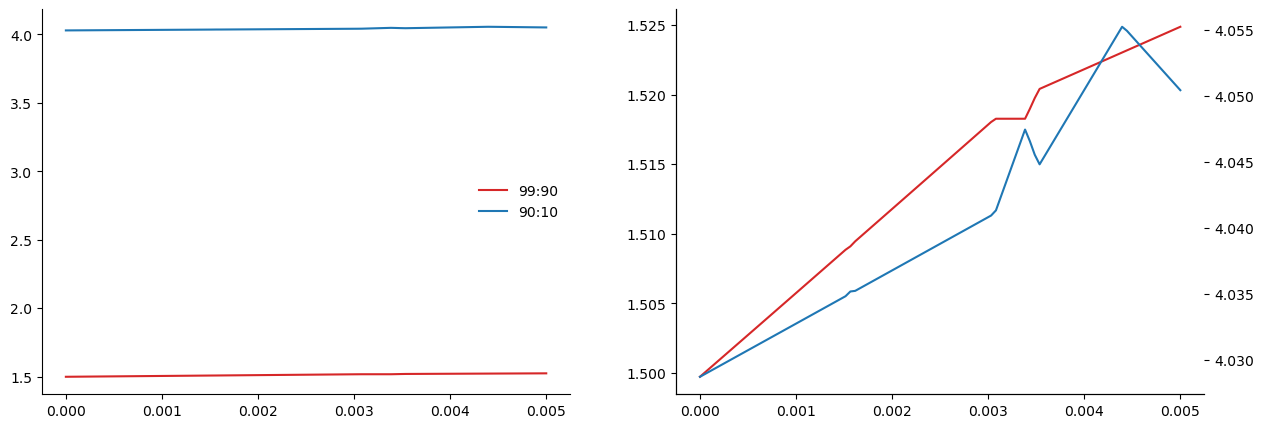

In [220]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
ax[0].plot(beta, ratio_a, c='C3', label='99:90')
ax[0].plot(beta, ratio_b, c='C0', label='90:10')

ax[1].plot(beta, ratio_a, c='C3')
axx = ax[1].twinx()
axx.plot(beta, ratio_b, c='C0')

ax[0].legend(frameon=False)
sns.despine()
# plt.plot(beta, ratio_b)

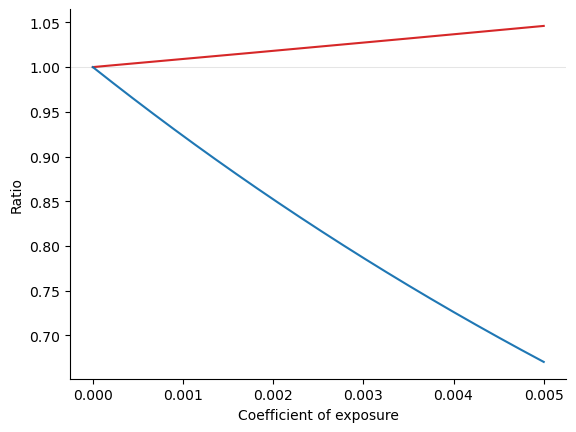

In [176]:
beta = np.linspace(0, .005, 500)
plt.plot(beta, np.exp(beta * 99) / np.exp(beta * 90), c='C3')
plt.plot(beta, np.exp(beta * 10) / np.exp(beta * 90), c='C0')
plt.xlabel('Coefficient of exposure')
plt.ylabel('Ratio')
plt.axhline(1, linestyle='-', linewidth=.8, c='k', alpha=.1)
sns.despine()